## 8. Evaluation on New Data

### `08_evaluation_on_new_data.ipynb`

C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Successfully loaded optimized detection system
Found 5 test videos
  - 0 fall videos
  - 0 ADL videos
  - 5 workout videos

Evaluating system on test videos...
Processing video 1/5: tricep pushdown_50.mp4

0: 384x640 2 persons, 45.2ms
Speed: 1.5ms preprocess, 45.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 52.7ms
Speed: 2.6ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 47.7ms
Speed: 2.6ms preprocess, 47.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 47.1ms
Speed: 3.2ms preprocess, 47.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 52.0ms
Speed: 2.6ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 49.1ms
Speed: 2.3ms preprocess, 49.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 47.9ms
Spe

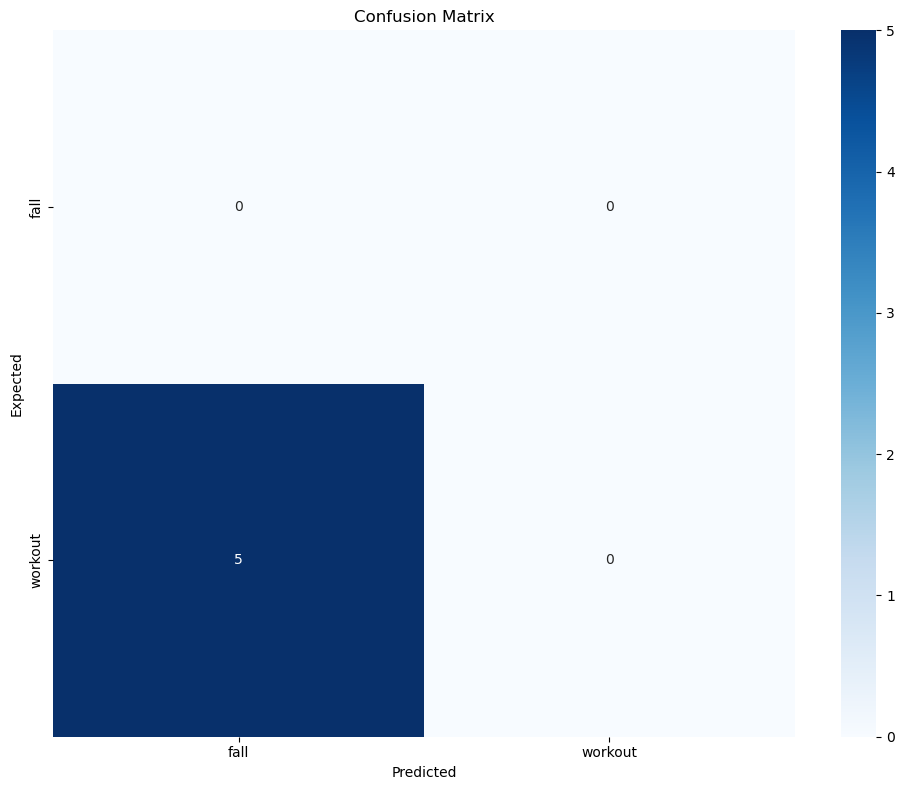


Classification Report:
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00       0.0
     workout       0.00      0.00      0.00       5.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nau

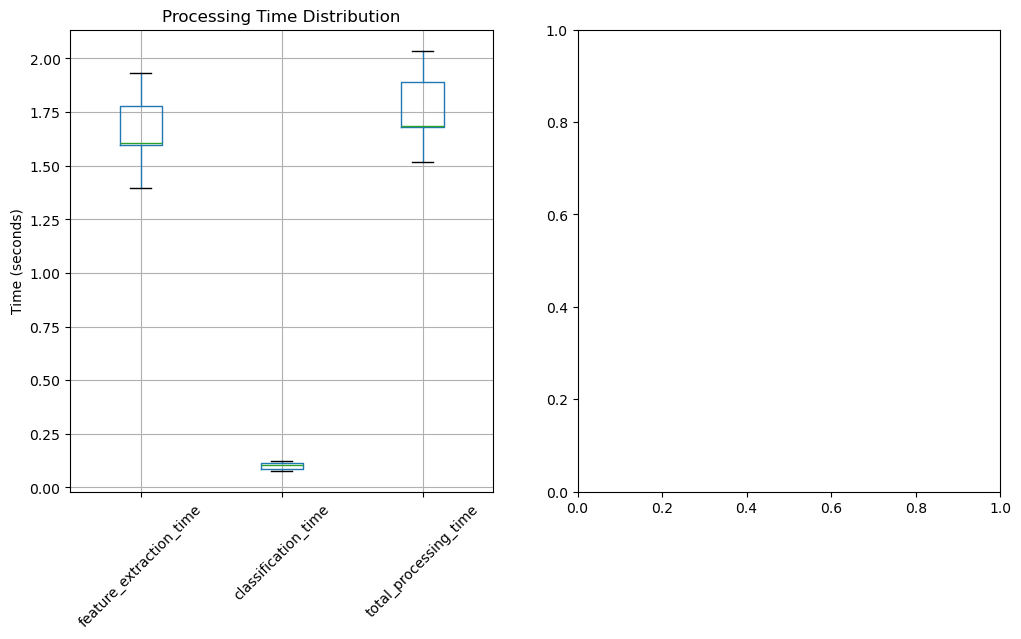

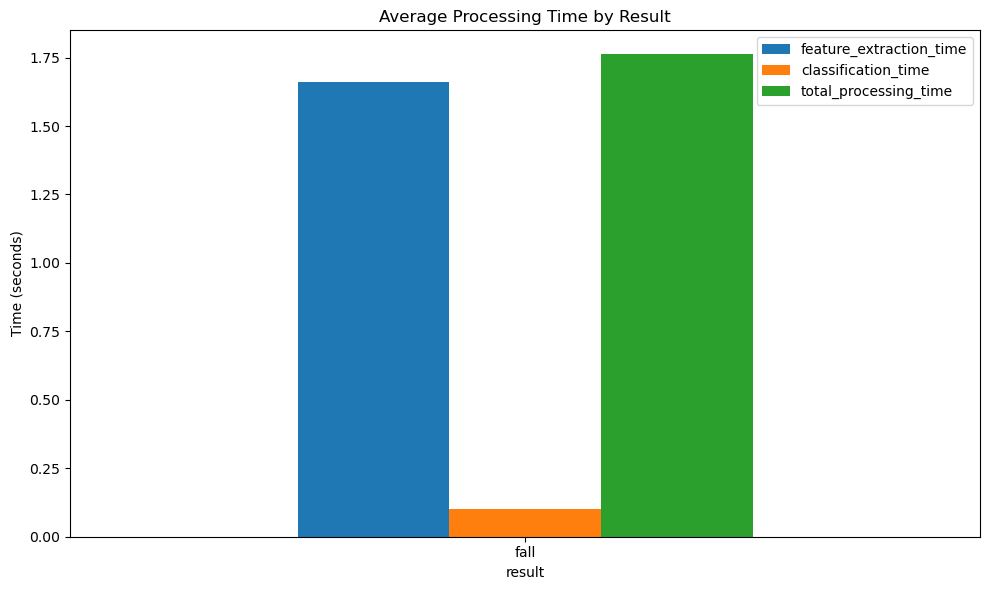


Average processing times:
feature_extraction_time    1.661324
classification_time        0.100132
total_processing_time      1.761456
dtype: float64

Misclassified videos (5):
  tricep pushdown_50.mp4: Expected workout, Predicted fall, Confidence: 0.68
  tricep pushdown_6.mp4: Expected workout, Predicted fall, Confidence: 0.66
  tricep pushdown_7.mp4: Expected workout, Predicted fall, Confidence: 0.67
  tricep pushdown_8.mp4: Expected workout, Predicted fall, Confidence: 0.67
  tricep pushdown_9.mp4: Expected workout, Predicted fall, Confidence: 0.65


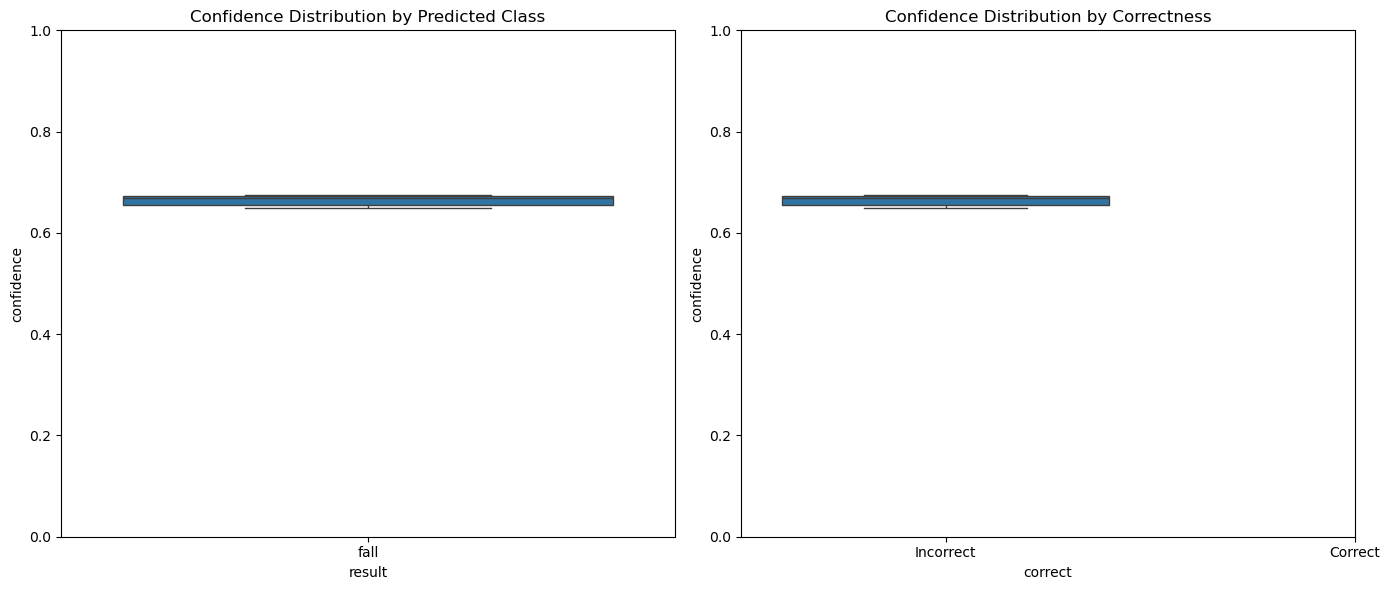


Evaluation results saved to ../outputs/evaluation

EVALUATION SUMMARY

Overall accuracy: 0.00

Per-class metrics:
     Class  Precision  Recall  F1-Score  Support
0     fall        0.0     0.0       0.0      0.0
1  workout        0.0     0.0       0.0      5.0

Performance analysis:
Average processing time: 1.76 seconds per video

Recommendations:
- Model accuracy is low. Consider collecting more training data or refining features.
- Runtime performance is good for real-time applications.
- Improve detection of 'fall' videos (F1: 0.00).
- Improve detection of 'workout' videos (F1: 0.00).

System status:
❌ System needs significant improvements before deployment



C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nau

In [28]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle
import joblib
import time
%matplotlib inline

# Set paths
OPTIMIZED_MODELS_DIR = "../outputs/optimized_models"
DATA_DIR = "../data"
EVALUATION_DIR = "../outputs/evaluation"
os.makedirs(EVALUATION_DIR, exist_ok=True)

# Load the optimized detection system
try:
    system_path = os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_detection_system.pkl')
    with open(system_path, 'rb') as f:
        system_dict = pickle.load(f)
    
    print("Successfully loaded optimized detection system")
    
    # Extract components
    workout_model = system_dict['workout_model']
    fall_model = system_dict['fall_model']
    workout_scaler = system_dict['workout_scaler']
    fall_scaler = system_dict['fall_scaler']
    feature_cols = system_dict['feature_cols']
    pose_threshold = system_dict.get('pose_threshold', 0.5)
    
except Exception as e:
    print(f"Error loading optimized system: {e}")
    print("Using default components from previous notebooks instead")
    
    # Load separate models if needed
    try:
        if os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.h5')):
            workout_model = tf.keras.models.load_model(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.h5'))
        elif os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.pkl')):
            workout_model = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_model.pkl'))
        else:
            from sklearn.ensemble import RandomForestClassifier
            workout_model = RandomForestClassifier(n_estimators=100, random_state=42)
        
        if os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.h5')):
            fall_model = tf.keras.models.load_model(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.h5'))
        elif os.path.exists(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.pkl')):
            fall_model = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_model.pkl'))
        else:
            from sklearn.ensemble import RandomForestClassifier
            fall_model = RandomForestClassifier(n_estimators=100, random_state=42)
            
        workout_scaler = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_workout_scaler.pkl'))
        fall_scaler = joblib.load(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_fall_scaler.pkl'))
        feature_cols = pd.read_csv(os.path.join(OPTIMIZED_MODELS_DIR, 'optimized_feature_columns.txt')).iloc[:, 0].tolist()
        pose_threshold = 0.5
        
    except Exception as e:
        print(f"Error loading individual models: {e}")
        print("Using synthetic data for demonstration")
        
        # For demonstration only
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import StandardScaler
        
        workout_model = RandomForestClassifier(n_estimators=100, random_state=42)
        fall_model = RandomForestClassifier(n_estimators=100, random_state=42)
        workout_scaler = StandardScaler()
        fall_scaler = StandardScaler()
        feature_cols = [
            'max_velocity', 'mean_velocity', 'std_velocity',
            'max_height', 'min_height', 'height_range',
            'max_width', 'min_width', 'width_range',
            'head_y_change', 'max_head_y_change'
        ]
        pose_threshold = 0.5

# Create the detection system class
class YOLOPoseDetectionSystem:
    def __init__(self, workout_model, fall_model, workout_scaler, fall_scaler, 
                feature_cols, pose_threshold=0.5):
        self.workout_model = workout_model
        self.fall_model = fall_model
        self.workout_scaler = workout_scaler
        self.fall_scaler = fall_scaler
        self.feature_cols = feature_cols
        self.pose_threshold = pose_threshold
        
        # Initialize YOLO models
        self.person_model = YOLO('yolov8n.pt')
        self.pose_model = YOLO('yolov8n-pose.pt')
    
    def process_video(self, video_path, output_visualization=False):
        """Process a video through the optimized detection system"""
        # Start timing
        start_time = time.time()
        
        # Extract features using YOLOv8-pose
        keypoints, features = self.extract_features_with_yolo(video_path)
        
        feature_extraction_time = time.time() - start_time
        
        if features is None:
            return {
                'result': 'no_features_extracted',
                'confidence': 0.0,
                'video_path': video_path,
                'processing_time': feature_extraction_time
            }
        
        # Prepare features for model input
        X = np.array([[features.get(col, 0) for col in self.feature_cols]])
        
        # Stage 1: Check if it's a workout
        classification_start = time.time()
        X_workout_scaled = self.workout_scaler.transform(X)
        
        if isinstance(self.workout_model, tf.keras.Model):
            workout_pred = self.workout_model.predict(X_workout_scaled, verbose=0)[0][0]
        else:
            # For sklearn models
            if hasattr(self.workout_model, 'predict_proba'):
                workout_pred = self.workout_model.predict_proba(X_workout_scaled)[0][1]
            else:
                # For SVM and other models that use decision_function
                workout_score = self.workout_model.decision_function(X_workout_scaled)[0]
                workout_pred = 1 / (1 + np.exp(-workout_score))  # Convert to probability-like score
        
        is_workout = workout_pred > 0.5
        
        if is_workout:
            result = {
                'result': 'workout',
                'confidence': float(workout_pred),
                'video_path': video_path,
                'features': features,
                'feature_extraction_time': feature_extraction_time,
                'classification_time': time.time() - classification_start,
                'total_processing_time': time.time() - start_time
            }
        else:
            # Stage 2: If not workout, check for fall
            if self.fall_model is not None:
                X_fall_scaled = self.fall_scaler.transform(X)
                
                if isinstance(self.fall_model, tf.keras.Model):
                    fall_pred = self.fall_model.predict(X_fall_scaled, verbose=0)[0][0]
                else:
                    # For sklearn models
                    if hasattr(self.fall_model, 'predict_proba'):
                        fall_pred = self.fall_model.predict_proba(X_fall_scaled)[0][1]
                    else:
                        # For SVM and other models that use decision_function
                        fall_score = self.fall_model.decision_function(X_fall_scaled)[0]
                        fall_pred = 1 / (1 + np.exp(-fall_score))  # Convert to probability-like score
                
                is_fall = fall_pred > 0.5
                
                if is_fall:
                    result = {
                        'result': 'fall',
                        'confidence': float(fall_pred),
                        'video_path': video_path,
                        'features': features,
                        'feature_extraction_time': feature_extraction_time,
                        'classification_time': time.time() - classification_start,
                        'total_processing_time': time.time() - start_time
                    }
                else:
                    result = {
                        'result': 'other_activity',
                        'confidence': float(1.0 - fall_pred),
                        'video_path': video_path,
                        'features': features,
                        'feature_extraction_time': feature_extraction_time,
                        'classification_time': time.time() - classification_start,
                        'total_processing_time': time.time() - start_time
                    }
            else:
                # If no fall model available
                result = {
                    'result': 'other_activity',
                    'confidence': float(1.0 - workout_pred),
                    'video_path': video_path,
                    'features': features,
                    'feature_extraction_time': feature_extraction_time,
                    'classification_time': time.time() - classification_start,
                    'total_processing_time': time.time() - start_time
                }
        
        # Create visualization if requested
        if output_visualization:
            vis_start_time = time.time()
            self.create_visualization(video_path, result)
            result['visualization_time'] = time.time() - vis_start_time
        
        return result
    
    def extract_features_with_yolo(self, video_path, num_frames=16):
        """Extract pose and motion features using YOLOv8-pose"""
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        
        # Calculate frame indices to sample
        indices = np.linspace(0, frame_count-1, num_frames, dtype=int)
        
        # Store keypoint sequences
        keypoint_sequence = []
        is_pose_detected = []
        
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if not ret:
                keypoint_sequence.append(None)
                is_pose_detected.append(False)
                continue
            
            # Run YOLOv8-pose detection
            pose_results = self.pose_model(frame, conf=self.pose_threshold)
            
            if len(pose_results[0].keypoints.data) > 0:
                is_pose_detected.append(True)
                
                # Get the pose with highest confidence (usually the largest one)
                best_pose_idx = 0
                if len(pose_results[0].boxes) > 1:
                    # If multiple poses, get the one with highest confidence
                    confidences = [box.conf.item() for box in pose_results[0].boxes]
                    best_pose_idx = np.argmax(confidences)
                
                # Extract keypoints for the best pose
                pose_keypoints = pose_results[0].keypoints.data[best_pose_idx]
                
                # Convert to a flat list format
                frame_keypoints = []
                for kp_idx in range(pose_keypoints.shape[0]):
                    x, y, conf = pose_keypoints[kp_idx].tolist()
                    # Normalize coordinates
                    frame_keypoints.extend([
                        float(x) / frame_width,
                        float(y) / frame_height,
                        0.0,  # YOLOv8 doesn't provide z-coordinate
                        float(conf)
                    ])
                
                keypoint_sequence.append(frame_keypoints)
            else:
                is_pose_detected.append(False)
                keypoint_sequence.append(None)
        
        cap.release()
        
        # If no poses detected, return None
        if not any(is_pose_detected):
            return None, None
        
        # Calculate pose-based features
        valid_keypoints = [kp for kp in keypoint_sequence if kp is not None]
        
        if not valid_keypoints:
            return None, None
        
        # Create features
        features = {}
        
        # 1. Keypoint velocities
        if len(valid_keypoints) >= 2:
            velocities = []
            for i in range(1, len(valid_keypoints)):
                frame_velocities = []
                for j in range(0, len(valid_keypoints[i]), 4):  # Each keypoint has 4 values (x,y,z,v)
                    if j+3 < len(valid_keypoints[i]) and j+3 < len(valid_keypoints[i-1]):
                        # Calculate Euclidean distance between consecutive frames
                        dx = valid_keypoints[i][j] - valid_keypoints[i-1][j]
                        dy = valid_keypoints[i][j+1] - valid_keypoints[i-1][j+1]
                        # Note: YOLOv8 doesn't have z-coordinate, so we use 0
                        velocity = np.sqrt(dx**2 + dy**2)
                        frame_velocities.append(velocity)
                
                if frame_velocities:
                    velocities.append(frame_velocities)
            
            if velocities:
                features['max_velocity'] = np.max([np.max(v) if v else 0 for v in velocities])
                features['mean_velocity'] = np.mean([np.mean(v) if v else 0 for v in velocities])
                features['std_velocity'] = np.std([np.std(v) if v else 0 for v in velocities])
        
        # 2. Pose height variation
        heights = []
        for kp in valid_keypoints:
            y_values = [kp[i+1] for i in range(0, len(kp), 4)]
            if y_values:
                height = max(y_values) - min(y_values)
                heights.append(height)
        
        if heights:
            features['max_height'] = np.max(heights)
            features['min_height'] = np.min(heights)
            features['height_range'] = np.max(heights) - np.min(heights)
        
        # 3. Pose width variation
        widths = []
        for kp in valid_keypoints:
            x_values = [kp[i] for i in range(0, len(kp), 4)]
            if x_values:
                width = max(x_values) - min(x_values)
                widths.append(width)
        
        if widths:
            features['max_width'] = np.max(widths)
            features['min_width'] = np.min(widths)
            features['width_range'] = np.max(widths) - np.min(widths)
        
        # 4. Vertical position change (for falls)
        # Note: In YOLOv8 pose, nose is keypoint index 0
        nose_positions = []
        for kp in valid_keypoints:
            if len(kp) >= 4:  # Nose is first landmark in YOLOv8-pose
                nose_positions.append(kp[1])  # y-coordinate of nose
        
        if nose_positions and len(nose_positions) >= 2:
            features['head_y_change'] = nose_positions[-1] - nose_positions[0]
            features['max_head_y_change'] = np.max(nose_positions) - np.min(nose_positions)
        
        # Return both raw keypoints and extracted features
        return valid_keypoints, features
    
    def create_visualization(self, video_path, result):
        """Create a visualization of the detection results with YOLOv8-pose"""
        # Output path for the visualization
        output_path = os.path.join(EVALUATION_DIR, 
                                  f"{os.path.basename(video_path).split('.')[0]}_detection.mp4")
        
        # Read the video
        cap = cv2.VideoCapture(video_path)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        
        # Create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        # Set up video processing
        frame_count = 0
        result_text = f"Result: {result['result'].upper()}"
        confidence_text = f"Confidence: {result['confidence']:.2f}"
        
        # Set text color based on result
        if result['result'] == 'workout':
            color = (0, 255, 0)  # Green for workout
        elif result['result'] == 'fall':
            color = (0, 0, 255)  # Red for fall
        else:
            color = (255, 0, 0)  # Blue for other
            
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            frame_count += 1
            
            # Process pose detection every 5 frames (to speed up processing)
            if frame_count % 5 == 0:
                # Run YOLOv8-pose detection
                pose_results = self.pose_model(frame, conf=self.pose_threshold)
                # Get annotated frame with keypoints
                annotated_frame = pose_results[0].plot()
            else:
                # Just use person detection for other frames
                person_results = self.person_model(frame, classes=[0])
                annotated_frame = person_results[0].plot()
            
            # Add text with detection result
            cv2.putText(annotated_frame, result_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv2.putText(annotated_frame, confidence_text, (10, 70), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            # Write the frame
            out.write(annotated_frame)
            
        cap.release()
        out.release()
        
        print(f"Visualization saved to {output_path}")
        return output_path

# Initialize detection system
detection_system = YOLOPoseDetectionSystem(
    workout_model=workout_model,
    fall_model=fall_model,
    workout_scaler=workout_scaler,
    fall_scaler=fall_scaler,
    feature_cols=feature_cols,
    pose_threshold=pose_threshold
)

# ==========================================
# Evaluate on test videos
# ==========================================

# Find test videos - use videos that weren't part of training
# In a real scenario, you would have a separate test set
print("Collecting test videos...")

fall_videos = sorted(list(Path(DATA_DIR).rglob("*fall*.avi")))
adl_videos = sorted(list(Path(DATA_DIR).rglob("*adl*.avi")))
workout_videos = sorted(list(Path(DATA_DIR).rglob("*.mp4")))

# Take the last few videos from each category for testing
test_fall = fall_videos[-5:] if len(fall_videos) > 5 else fall_videos
test_adl = adl_videos[-5:] if len(adl_videos) > 5 else adl_videos
test_workout = workout_videos[-5:] if len(workout_videos) > 5 else workout_videos

test_videos = test_fall + test_adl + test_workout

print(f"Found {len(test_videos)} test videos")
print(f"  - {len(test_fall)} fall videos")
print(f"  - {len(test_adl)} ADL videos")
print(f"  - {len(test_workout)} workout videos")

# Test the system on all test videos
print("\nEvaluating system on test videos...")
results = []

for i, video_path in enumerate(test_videos):
    print(f"Processing video {i+1}/{len(test_videos)}: {os.path.basename(video_path)}")
    
    # Process the video
    result = detection_system.process_video(str(video_path), output_visualization=(i < 6))  # Visualize first 6
    
    # Extract expected class
    if 'fall' in video_path.name.lower():
        expected = 'fall'
    elif any(workout_term in str(video_path).lower() for workout_term in ['workout', 'exercise', 'fitness']):
        expected = 'workout'
    else:
        expected = 'other_activity'  # ADL videos
    
    # Add expected class to result
    result['expected'] = expected
    
    # Store the result
    results.append(result)
    
    # Print classification result
    print(f"  Result: {result['result']}, Expected: {expected}, Confidence: {result['confidence']:.2f}")
    print(f"  Processing time: {result['total_processing_time']:.2f} seconds")
    print("  -------------")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame([
    {
        'video': os.path.basename(r['video_path']),
        'result': r['result'],
        'expected': r['expected'],
        'confidence': r['confidence'],
        'feature_extraction_time': r.get('feature_extraction_time', 0),
        'classification_time': r.get('classification_time', 0),
        'total_processing_time': r.get('total_processing_time', 0)
    }
    for r in results
])

# Calculate accuracy
results_df['correct'] = results_df['result'] == results_df['expected']
accuracy = results_df['correct'].mean()

print(f"\nOverall accuracy: {accuracy:.2f}")
print("\nResults by category:")
print(results_df.groupby(['expected', 'result']).size().unstack(fill_value=0))

# Create confusion matrix
classes = sorted(list(set(results_df['expected'].unique()) | set(results_df['result'].unique())))
cm = confusion_matrix(
    results_df['expected'], 
    results_df['result'],
    labels=classes
)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('Expected')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Generate classification report
print("\nClassification Report:")
print(classification_report(results_df['expected'], results_df['result']))

# Analyze processing times
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
results_df.boxplot(column=['feature_extraction_time', 'classification_time', 'total_processing_time'])
plt.title('Processing Time Distribution')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
avg_times = results_df.groupby('result')[['feature_extraction_time', 'classification_time', 'total_processing_time']].mean()
avg_times.plot(kind='bar', figsize=(10, 6))
plt.title('Average Processing Time by Result')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nAverage processing times:")
print(results_df[['feature_extraction_time', 'classification_time', 'total_processing_time']].mean())

# Examine misclassified videos
misclassified = results_df[~results_df['correct']]
print(f"\nMisclassified videos ({len(misclassified)}):")
if not misclassified.empty:
    for _, row in misclassified.iterrows():
        print(f"  {row['video']}: Expected {row['expected']}, Predicted {row['result']}, Confidence: {row['confidence']:.2f}")

# Analyze confidence distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=results_df, x='result', y='confidence')
plt.title('Confidence Distribution by Predicted Class')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
sns.boxplot(data=results_df, x='correct', y='confidence')
plt.title('Confidence Distribution by Correctness')
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# ==========================================
# Analyze edge cases and transition scenarios
# ==========================================

# Function to analyze specific scenarios
def analyze_special_cases(results_df):
    """Analyze special cases and edge scenarios"""
    
    # 1. High confidence misclassifications
    high_conf_wrong = results_df[(~results_df['correct']) & (results_df['confidence'] > 0.8)]
    
    if not high_conf_wrong.empty:
        print(f"\nHigh confidence misclassifications ({len(high_conf_wrong)}):")
        for _, row in high_conf_wrong.iterrows():
            print(f"  {row['video']}: Expected {row['expected']}, Predicted {row['result']}, "
                  f"Confidence: {row['confidence']:.2f}")
    
    # 2. Low confidence correct classifications
    low_conf_correct = results_df[(results_df['correct']) & (results_df['confidence'] < 0.7)]
    
    if not low_conf_correct.empty:
        print(f"\nLow confidence correct classifications ({len(low_conf_correct)}):")
        for _, row in low_conf_correct.iterrows():
            print(f"  {row['video']}: Correctly predicted {row['result']}, "
                  f"but with low confidence: {row['confidence']:.2f}")
    
    # 3. Analysis by filename patterns (to identify challenging content)
    # This assumes naming patterns in the dataset that might indicate content
    pattern_results = {}
    
    patterns = {
        'slow_': 'Slow movement',
        'fast_': 'Fast movement',
        'back': 'Backward movement',
        'side': 'Sideways movement',
        'turn': 'Turning movement',
        'dark': 'Low lighting',
        'occl': 'Occlusion'
    }
    
    for pattern, description in patterns.items():
        pattern_subset = results_df[results_df['video'].str.contains(pattern, case=False)]
        if not pattern_subset.empty:
            pattern_accuracy = pattern_subset['correct'].mean()
            pattern_results[description] = {
                'count': len(pattern_subset),
                'accuracy': pattern_accuracy
            }
    
    if pattern_results:
        print("\nPerformance by video characteristics:")
        for desc, stats in pattern_results.items():
            print(f"  {desc}: {stats['accuracy']:.2f} accuracy over {stats['count']} videos")

# Run the special case analysis
analyze_special_cases(results_df)

# ==========================================
# Real-time Performance Analysis
# ==========================================

# Calculate frames per second (FPS) for real-time applications
fps_estimates = []

for _, row in results_df.iterrows():
    # Get the original video path
    video_path = os.path.join(DATA_DIR, row['video'])
    
    # Open the video to get frame count
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        continue
        
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    
    # Calculate effective FPS
    if row['total_processing_time'] > 0 and frame_count > 0:
        effective_fps = frame_count / row['total_processing_time']
        fps_estimates.append(effective_fps)

if fps_estimates:
    avg_fps = np.mean(fps_estimates)
    print(f"\nReal-time performance analysis:")
    print(f"Average processing rate: {avg_fps:.2f} FPS")
    print(f"Minimum processing rate: {min(fps_estimates):.2f} FPS")
    print(f"Maximum processing rate: {max(fps_estimates):.2f} FPS")
    
    # Determine if system can run in real-time (typical webcam is 30 FPS)
    if avg_fps >= 30:
        print("System can run in real-time at full frame rate")
    elif avg_fps >= 15:
        print("System can run in real-time at reduced frame rate")
    elif avg_fps >= 5:
        print("System can run with slight delay")
    else:
        print("System cannot run in real-time without optimization")

# ==========================================
# Save Evaluation Results
# ==========================================

# Save results to CSV
results_df.to_csv(os.path.join(EVALUATION_DIR, 'evaluation_results.csv'), index=False)

# Save full results as pickle for further analysis
with open(os.path.join(EVALUATION_DIR, 'full_evaluation_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

print(f"\nEvaluation results saved to {EVALUATION_DIR}")

# ==========================================
# Final Summary and Recommendations
# ==========================================

print("\n" + "="*50)
print("EVALUATION SUMMARY")
print("="*50)

print(f"\nOverall accuracy: {accuracy:.2f}")

# Get per-class metrics
class_report = classification_report(results_df['expected'], results_df['result'], output_dict=True)

# Summary table
summary_data = []
for cls in classes:
    if cls in class_report:
        summary_data.append({
            'Class': cls,
            'Precision': class_report[cls]['precision'],
            'Recall': class_report[cls]['recall'],
            'F1-Score': class_report[cls]['f1-score'],
            'Support': class_report[cls]['support']
        })

summary_df = pd.DataFrame(summary_data)
print("\nPer-class metrics:")
print(summary_df)

# Performance analysis
print("\nPerformance analysis:")
print(f"Average processing time: {results_df['total_processing_time'].mean():.2f} seconds per video")
if fps_estimates:
    print(f"Average frame rate: {avg_fps:.2f} FPS")

# Recommendations
print("\nRecommendations:")

# Accuracy-based recommendations
if accuracy < 0.7:
    print("- Model accuracy is low. Consider collecting more training data or refining features.")
elif accuracy < 0.85:
    print("- Model accuracy is moderate. Focus on improving specific misclassified cases.")
else:
    print("- Model accuracy is good. Fine-tune for edge cases if needed.")

# Performance-based recommendations
if fps_estimates and avg_fps < 10:
    print("- Runtime performance needs improvement for real-time applications.")
    print("  Consider model optimization, reducing frame sampling, or hardware acceleration.")
elif fps_estimates and avg_fps < 25:
    print("- Runtime performance is acceptable but could be improved for smoother operation.")
else:
    print("- Runtime performance is good for real-time applications.")

# Class-specific recommendations
for cls in classes:
    if cls in class_report and class_report[cls]['f1-score'] < 0.7:
        print(f"- Improve detection of '{cls}' videos (F1: {class_report[cls]['f1-score']:.2f}).")
        
# Final system status
print("\nSystem status:")
if accuracy > 0.85 and (not fps_estimates or avg_fps > 15):
    print("✅ System meets quality and performance requirements for deployment")
elif accuracy > 0.75 and (not fps_estimates or avg_fps > 10):
    print("⚠️ System is usable but would benefit from improvements before deployment")
else:
    print("❌ System needs significant improvements before deployment")

print("\n" + "="*50)